<a href="https://colab.research.google.com/github/nischitabiradar/BDA-696-Project---Fashion-Product-Classification-and-Recommendation/blob/main/Final_ResNet50_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp '/content/kaggle (1).json' ~/.kaggle/kaggle.json

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d paramaggarwal/fashion-product-images-small

 98% 553M/565M [00:07<00:00, 117MB/s]
100% 565M/565M [00:07<00:00, 79.6MB/s]


In [ ]:
! unzip fashion-product-images-small.zip

In [9]:
#packages and libraries
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import v2
import time
import copy
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [10]:
# Path to CSV file
csv_file_path = '/content/myntradataset/styles.csv'

try:
    # Attempt to read the CSV file with initial row count
    initial_row_count = sum(1 for _ in open(csv_file_path)) - 1  # excluding header
    df = pd.read_csv(csv_file_path, on_bad_lines='skip')

    # Counting the number of rows read
    final_row_count = df.shape[0]
    skipped_rows = initial_row_count - final_row_count
    print(f"Number of rows skipped due to errors: {skipped_rows}")

    # Efficiently creating the 'image' column
    df['image'] = df['id'].astype(str) + ".jpg"
    df = df.reset_index(drop=True)

except Exception as e:
    print(f"An error occurred: {e}")

df.head(5)

Number of rows skipped due to errors: 22


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg


In [12]:
#Accessing Class Imbalance
class_counts = df['articleType'].value_counts()

max_class = class_counts.idxmax()
max_count = class_counts.max()

min_class = class_counts.idxmin()
min_count = class_counts.min()


print(f"Class with the most images: {max_class}, Count: {max_count}")
print(f"Class with the least images: {min_class}, Count: {min_count}")

Class with the most images: Tshirts, Count: 7067
Class with the least images: Hair Accessory, Count: 1


In [13]:
N_Pictures = 275
# Calculate the number of images per class
images_per_class = df.articleType.value_counts()

# Filter classes with more than N_Pictures images
sufficient_images = images_per_class[images_per_class > N_Pictures]

# Number of classes with sufficient images to train on
N_Classes = len(sufficient_images)

# Display the count of classes and the classes with their image counts
print(f"Number of classes with more than {N_Pictures} images: {N_Classes}")
print("Classes and their image counts:")
print(sufficient_images)


Number of classes with more than 275 images: 35
Classes and their image counts:
Tshirts                  7067
Shirts                   3217
Casual Shoes             2845
Watches                  2542
Sports Shoes             2036
Kurtas                   1844
Tops                     1762
Handbags                 1759
Heels                    1323
Sunglasses               1073
Wallets                   936
Flip Flops                914
Sandals                   897
Briefs                    849
Belts                     813
Backpacks                 724
Socks                     686
Formal Shoes              637
Perfume and Body Mist     613
Jeans                     609
Shorts                    547
Trousers                  530
Flats                     500
Bra                       477
Dresses                   464
Sarees                    427
Earrings                  416
Deodorant                 347
Nail Polish               329
Lipstick                  315
Track Pants         

In [14]:
#Saving item types(labels) with their counts
items_count = sufficient_images.values
items_label = sufficient_images.index.tolist()

In [15]:
#Creating new dataframes for training/validation
df_train = pd.DataFrame(columns=['articleType','image'])
df_val   = pd.DataFrame(columns=['articleType','image'])


for ii in range(0,N_Classes):

    #print(items_label[ii])

    temp = df[df.articleType==items_label[ii]].sample(N_Pictures)

    df_train = pd.concat([df_train, temp[ :int(N_Pictures*0.6) ][['articleType','image']] ]            , sort=False)
    df_val   = pd.concat([df_val,   temp[  int(N_Pictures*0.6): N_Pictures ][['articleType','image']] ], sort=False)

df_train.reset_index(drop=True)
df_val.reset_index(drop=True)

,articleType,image
0,Tshirts,16435.jpg
1,Tshirts,10031.jpg
2,Tshirts,7647.jpg
3,Tshirts,9557.jpg
4,Tshirts,3108.jpg
...,...,...
3845,Sweaters,18569.jpg
3846,Sweaters,13828.jpg
3847,Sweaters,11074.jpg
3848,Sweaters,20231.jpg


In [16]:
import os
import logging
from PIL import Image

# Set the path to the dataset
DATASET_PATH = '/content/myntradataset'  # Adjust this path to where your dataset is located

# Function to save images in organized directories
def save_images(data, dataset_path, target_root='data'):
    # Create the necessary directories for the dataset if they do not exist
    for phase in data:
        os.makedirs(os.path.join(target_root, phase), exist_ok=True)

    # Process and save images
    for phase in data:
        logging.info(f"Processing {phase} data")
        # Make sure to select only the 'label' and 'filename' columns
        for label, filename in data[phase][['articleType', 'image']].values:
            src_file_path = os.path.join(dataset_path, 'images', filename)
            target_dir_path = os.path.join(target_root, phase, label)
            target_file_path = os.path.join(target_dir_path, filename)

            # Ensure target directory exists
            os.makedirs(target_dir_path, exist_ok=True)

            try:
                with Image.open(src_file_path) as img:
                    img.save(target_file_path)
            except FileNotFoundError:
                logging.warning(f"File not found: {src_file_path}")
            except Exception as e:
                logging.error(f"Error saving file {target_file_path}: {e}")

# Set up logging
logging.basicConfig(level=logging.INFO)

# Assuming df_train and df_val are your DataFrames with 'articleType' and 'image' columns
data = {'train': df_train, 'val': df_val}

# Call the function
save_images(data, DATASET_PATH)


In [14]:
#Inspect if all the folders have been created
%ls data/train/

 Backpacks/       Deodorant/       Heels/                    Sarees/          Sweatshirts/
 Belts/           Dresses/         Jeans/                    Shirts/          Tops/
 Bra/             Earrings/        Kurtas/                   Shorts/         'Track Pants'/
 Briefs/          Flats/           Lipstick/                 Socks/           Trousers/
 Caps/           'Flip Flops'/    'Nail Polish'/            'Sports Shoes'/   Tshirts/
'Casual Shoes'/  'Formal Shoes'/  'Perfume and Body Mist'/   Sunglasses/      Wallets/
 Clutches/        Handbags/        Sandals/                  Sweaters/        Watches/


In [17]:
data_transforms = {

    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    ]),
}

data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


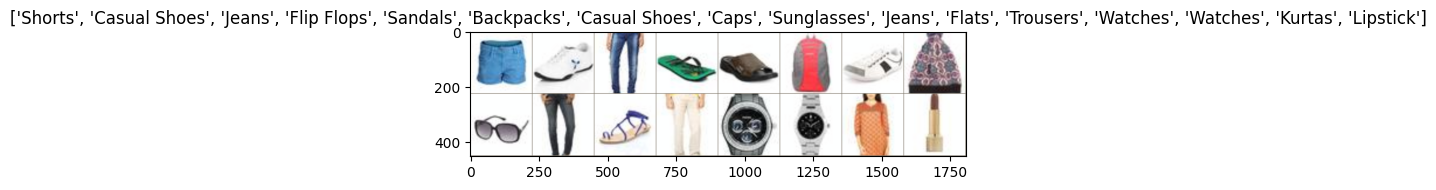

In [18]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [19]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model



In [20]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [21]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

#Changing the number of outputs in the last layer to the number of different item types
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 143MB/s]


In [22]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=11)

Epoch 0/10
----------
train Loss: 1.4978 Acc: 0.5953
val Loss: 0.5835 Acc: 0.7904

Epoch 1/10
----------
train Loss: 0.5454 Acc: 0.8222
val Loss: 0.4287 Acc: 0.8460

Epoch 2/10
----------
train Loss: 0.3908 Acc: 0.8748
val Loss: 0.4059 Acc: 0.8590

Epoch 3/10
----------
train Loss: 0.2844 Acc: 0.9044
val Loss: 0.3773 Acc: 0.8683

Epoch 4/10
----------
train Loss: 0.2356 Acc: 0.9243
val Loss: 0.3576 Acc: 0.8764

Epoch 5/10
----------
train Loss: 0.1601 Acc: 0.9539
val Loss: 0.3626 Acc: 0.8769

Epoch 6/10
----------
train Loss: 0.1193 Acc: 0.9661
val Loss: 0.3811 Acc: 0.8829

Epoch 7/10
----------
train Loss: 0.0707 Acc: 0.9848
val Loss: 0.3307 Acc: 0.8927

Epoch 8/10
----------
train Loss: 0.0572 Acc: 0.9896
val Loss: 0.3413 Acc: 0.8958

Epoch 9/10
----------
train Loss: 0.0491 Acc: 0.9938
val Loss: 0.3326 Acc: 0.8938

Epoch 10/10
----------
train Loss: 0.0470 Acc: 0.9927
val Loss: 0.3401 Acc: 0.8940

Training complete in 13m 58s
Best val Acc: 0.895844


In [23]:
#Saving our model's weights:

%mkdir model
torch.save(model_ft.state_dict(), 'model/model_fine_tuned.pt')
%ls

#Download the model weights and save them locally
from IPython.display import FileLink
FileLink(r'model/model_fine_tuned.pt')

 data/                              images/            model/           sample_data/
 fashion-product-images-small.zip  'kaggle (1).json'   myntradataset/   styles.csv


/content/model/model_fine_tuned.pt

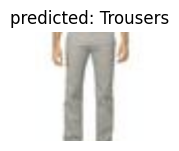

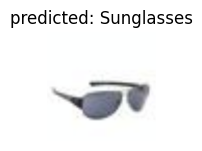

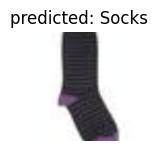

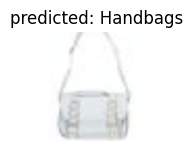

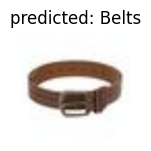

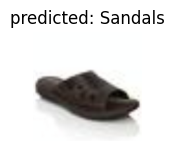

In [24]:
visualize_model(model_ft)

In [31]:
import requests

def classify_image_with_input(model, device, data_transforms, class_names):
    # Prompt for image URL
    url = input("Please enter the URL of the image: ")

    # Download the image
    response = requests.get(url, stream=True)
    img = Image.open(response.raw)
    del response

    # Transform the image
    img_t = data_transforms['val'](img).unsqueeze(0)
    img_t = img_t.to(device)

    # Predict the class
    model.eval()
    with torch.no_grad():
        outputs = model(img_t)
        _, preds = torch.max(outputs, 1)
        predicted_class = class_names[int(preds.cpu().numpy())]

    return predicted_class

# Example usage:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming data_transforms and class_names are defined and model_ft is loaded
predicted_class = classify_image_with_input(model_ft, device, data_transforms, class_names)
print("Predicted class:", predicted_class)


Please enter the URL of the image: https://cfs3.monicavinader.com/images/pdp-full/14347345-gp-ea-swer-gro-f1.jpg
Predicted class: Earrings
